In [1]:
from numba import config

# set the threading layer before any parallel target compilation
config.THREADING_LAYER = 'safe'

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from automated_scoring.config import cfg
from automated_scoring.io import load_dataset, save_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.classification import (
    predict,
    plot_confusion_matrix,
    plot_classification_timeline,
)
from automated_scoring.sliding_metrics import sliding_median
from automated_scoring.utils import ensure_generator
from automated_scoring.logging import set_logging_level

from helpers import subsample_train

In [4]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)


from functools import partial

def smooth(median_filter_window, *, array):
    return sliding_median(array, int(median_filter_window))


best_smoothing_parameters = (
    {'median_filter_window_attack': 59.0},
    {'median_filter_window_investigation': 7.0},
    {'median_filter_window_mount': 21.0},
    {'median_filter_window_none': 5.0},
)
best_thresholds = ({"threshold_attack": 0.32}, {"threshold_investigation": 0.0}, {"threshold_mount": 0.0}, {"threshold_none": 0.0})

smoothing_funcs = [partial(smooth, list(result.values())[0]) for result in best_smoothing_parameters]
thresholds = [list(results.values())[0] for results in best_thresholds]

smoothing_funcs, thresholds

([functools.partial(<function smooth at 0x7afb6d01c5e0>, 59.0),
  functools.partial(<function smooth at 0x7afb6d01c5e0>, 7.0),
  functools.partial(<function smooth at 0x7afb6d01c5e0>, 21.0),
  functools.partial(<function smooth at 0x7afb6d01c5e0>, 5.0)],
 [0.32, 0.0, 0.0, 0.0])

In [5]:
# load training and test datasets
dataset_train = load_dataset("mice_train", directory="../../datasets/CALMS21/train", target="dyad", background_category="none")
dataset_test = load_dataset("mice_test", directory="../../datasets/CALMS21/test", target="dyad", background_category="none")

# initialize a feature extractor from a configuration file
extractor = DataFrameFeatureExtractor(
    cache_directory="feature_cache_mice"
).read_yaml("config_file.yaml")

# set a fixed random state for reproducible results
random_state = ensure_generator(1)

# subsample dataset and encode target from string to numeric
X, y = subsample_train(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    random_state=random_state,
    log=None,
)
y = dataset_train.encode(y)

# specify and fit classification model
classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
    X.to_numpy(), y, sample_weight=compute_sample_weight('balanced', y)
)

# use model for predictions on the test dataset
test_result = predict(
    dataset_test.exclude_individuals(["intruder"]), classifier, extractor, log=None,
)

# save the classification result as a dataset
# additionally, apply a smoothing filter and custom decision thresholds

save_dataset(
    test_result.smooth(
        smoothing_funcs,
        decision_thresholds=thresholds,
    ).to_dataset(
        trajectories={
            identifier: group.trajectories
            for identifier, group in dataset_test
        },
        background_category="none",
    ),
    directory="../../datasets/CALMS21/pred",
    dataset_name="mice_pred",
    observation_suffix="predictions",
)

2025-02-19 14:00:21.454 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-02-19 14:00:22.058 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [6]:
def summarize_scores(result, iteration, prediction_step, f1_target, foregroud_categories_index, encode_func):
    f1 = result.f1_score(f1_target, encode_func=encode_func)
    return {
        "iteration": iteration,
        "step": prediction_step,
        "f1_macro_foreground": f1[foregroud_categories_index].mean(),
        "f1_macro": f1.mean(),
        **{f"f1_{category}": value for category, value in zip(result.categories, f1)}
    }


num_iterations = 20

scores = {"timestamp": [], "annotation": [], "prediction": []}
confusion = {f1_target: [] for f1_target in scores}

confusion["timestamp"] = []
confusion["annotation"] = []
confusion["prediction"] = []

for iteration in tqdm(range(1, 1 + num_iterations)):
    random_state = ensure_generator(iteration)

    # training pipeline as above
    X, y = subsample_train(
        dataset_train.exclude_individuals(["intruder"]),
        extractor,
        random_state=random_state,
        log=None,
    )
    y = dataset_train.encode(y)

    classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
        X.to_numpy(), y, sample_weight=compute_sample_weight('balanced', y)
    )

    # evaluate raw model outputs
    test_result = predict(dataset_test.exclude_individuals(["intruder"]), classifier, extractor, log=None)
    for f1_target in scores.keys():
        scores[f1_target].append(
            summarize_scores(
                test_result, iteration, "model_outputs", f1_target, [0, 1, 2], dataset_train.encode
            )
        )

    # evaluate after smoothing predictions
    test_result = test_result.smooth(smoothing_funcs)
    for f1_target in scores.keys():
        scores[f1_target].append(
            summarize_scores(
                test_result, iteration, "smoothing", f1_target, [0, 1, 2], dataset_train.encode
            )
        )

    # evaluate with thresholded predictions
    test_result = test_result.threshold(thresholds)
    for f1_target in scores.keys():
        scores[f1_target].append(
            summarize_scores(
                test_result, iteration, "thresholding", f1_target, [0, 1, 2], dataset_train.encode
            )
        )

    confusion["timestamp"].append(
        (test_result.y_true_numeric, test_result.y_pred_numeric)
    )
    confusion["annotation"].append(
        (
            dataset_test.encode(test_result.annotations["category"].to_numpy()),
            dataset_test.encode(test_result.annotations["predicted_category"].to_numpy()),
        )
    )
    confusion["prediction"].append(
        (
            dataset_test.encode(test_result.predictions["true_category"].to_numpy()),
            dataset_test.encode(test_result.predictions["category"].to_numpy()),
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
scores["timestamp"] = pd.DataFrame(scores["timestamp"])
scores["timestamp"].drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.783  0.002    0.825  0.001     0.637  0.003   
smoothing                   0.837  0.001    0.866  0.001     0.756  0.003   
thresholding                0.840  0.002    0.868  0.001     0.763  0.004   

              f1_investigation        f1_mount        f1_none       
                          mean    std     mean    std    mean  std  
step                                                                
model_outputs            0.809  0.002    0.902  0.001   0.951  0.0  
smoothing                0.840  0.002    0.916  0.001   0.953  0.0  
thresholding             0.844  0.002    0.913  0.001   0.953  0.0

In [9]:
scores["annotation"] = pd.DataFrame(scores["annotation"])
scores["annotation"].drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.743  0.005    0.774  0.004     0.609  0.007   
smoothing                   0.738  0.003    0.768  0.003     0.606  0.005   
thresholding                0.732  0.003    0.763  0.003     0.590  0.004   

              f1_investigation        f1_mount        f1_none         
                          mean    std     mean    std    mean    std  
step                                                                  
model_outputs            0.751  0.006    0.868  0.006   0.869  0.004  
smoothing                0.760  0.005    0.848  0.005   0.859  0.003  
thresholding             0.768  0.005    0.839  0.005   0.857  0.004

In [10]:
scores["prediction"] = pd.DataFrame(scores["prediction"])
scores["prediction"].drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.439  0.002    0.475  0.002     0.371  0.004   
smoothing                   0.665  0.006    0.696  0.005     0.585  0.009   
thresholding                0.669  0.006    0.699  0.006     0.613  0.011   

              f1_investigation        f1_mount        f1_none         
                          mean    std     mean    std    mean    std  
step                                                                  
model_outputs            0.550  0.003    0.397  0.005   0.583  0.006  
smoothing                0.729  0.004    0.681  0.009   0.788  0.006  
thresholding             0.742  0.004    0.652  0.009   0.789  0.006

In [12]:
# from observation_library.utils import adjust_lightness

def adjust_lightness(color, amount):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


import matplotlib.transforms as transforms

colors = [
    "#fc8d62",
    "#8da0cb",
    "#66c2a5",
    "#dddddd",
]
category_labels = ["att", "inv", "mnt", "other"]

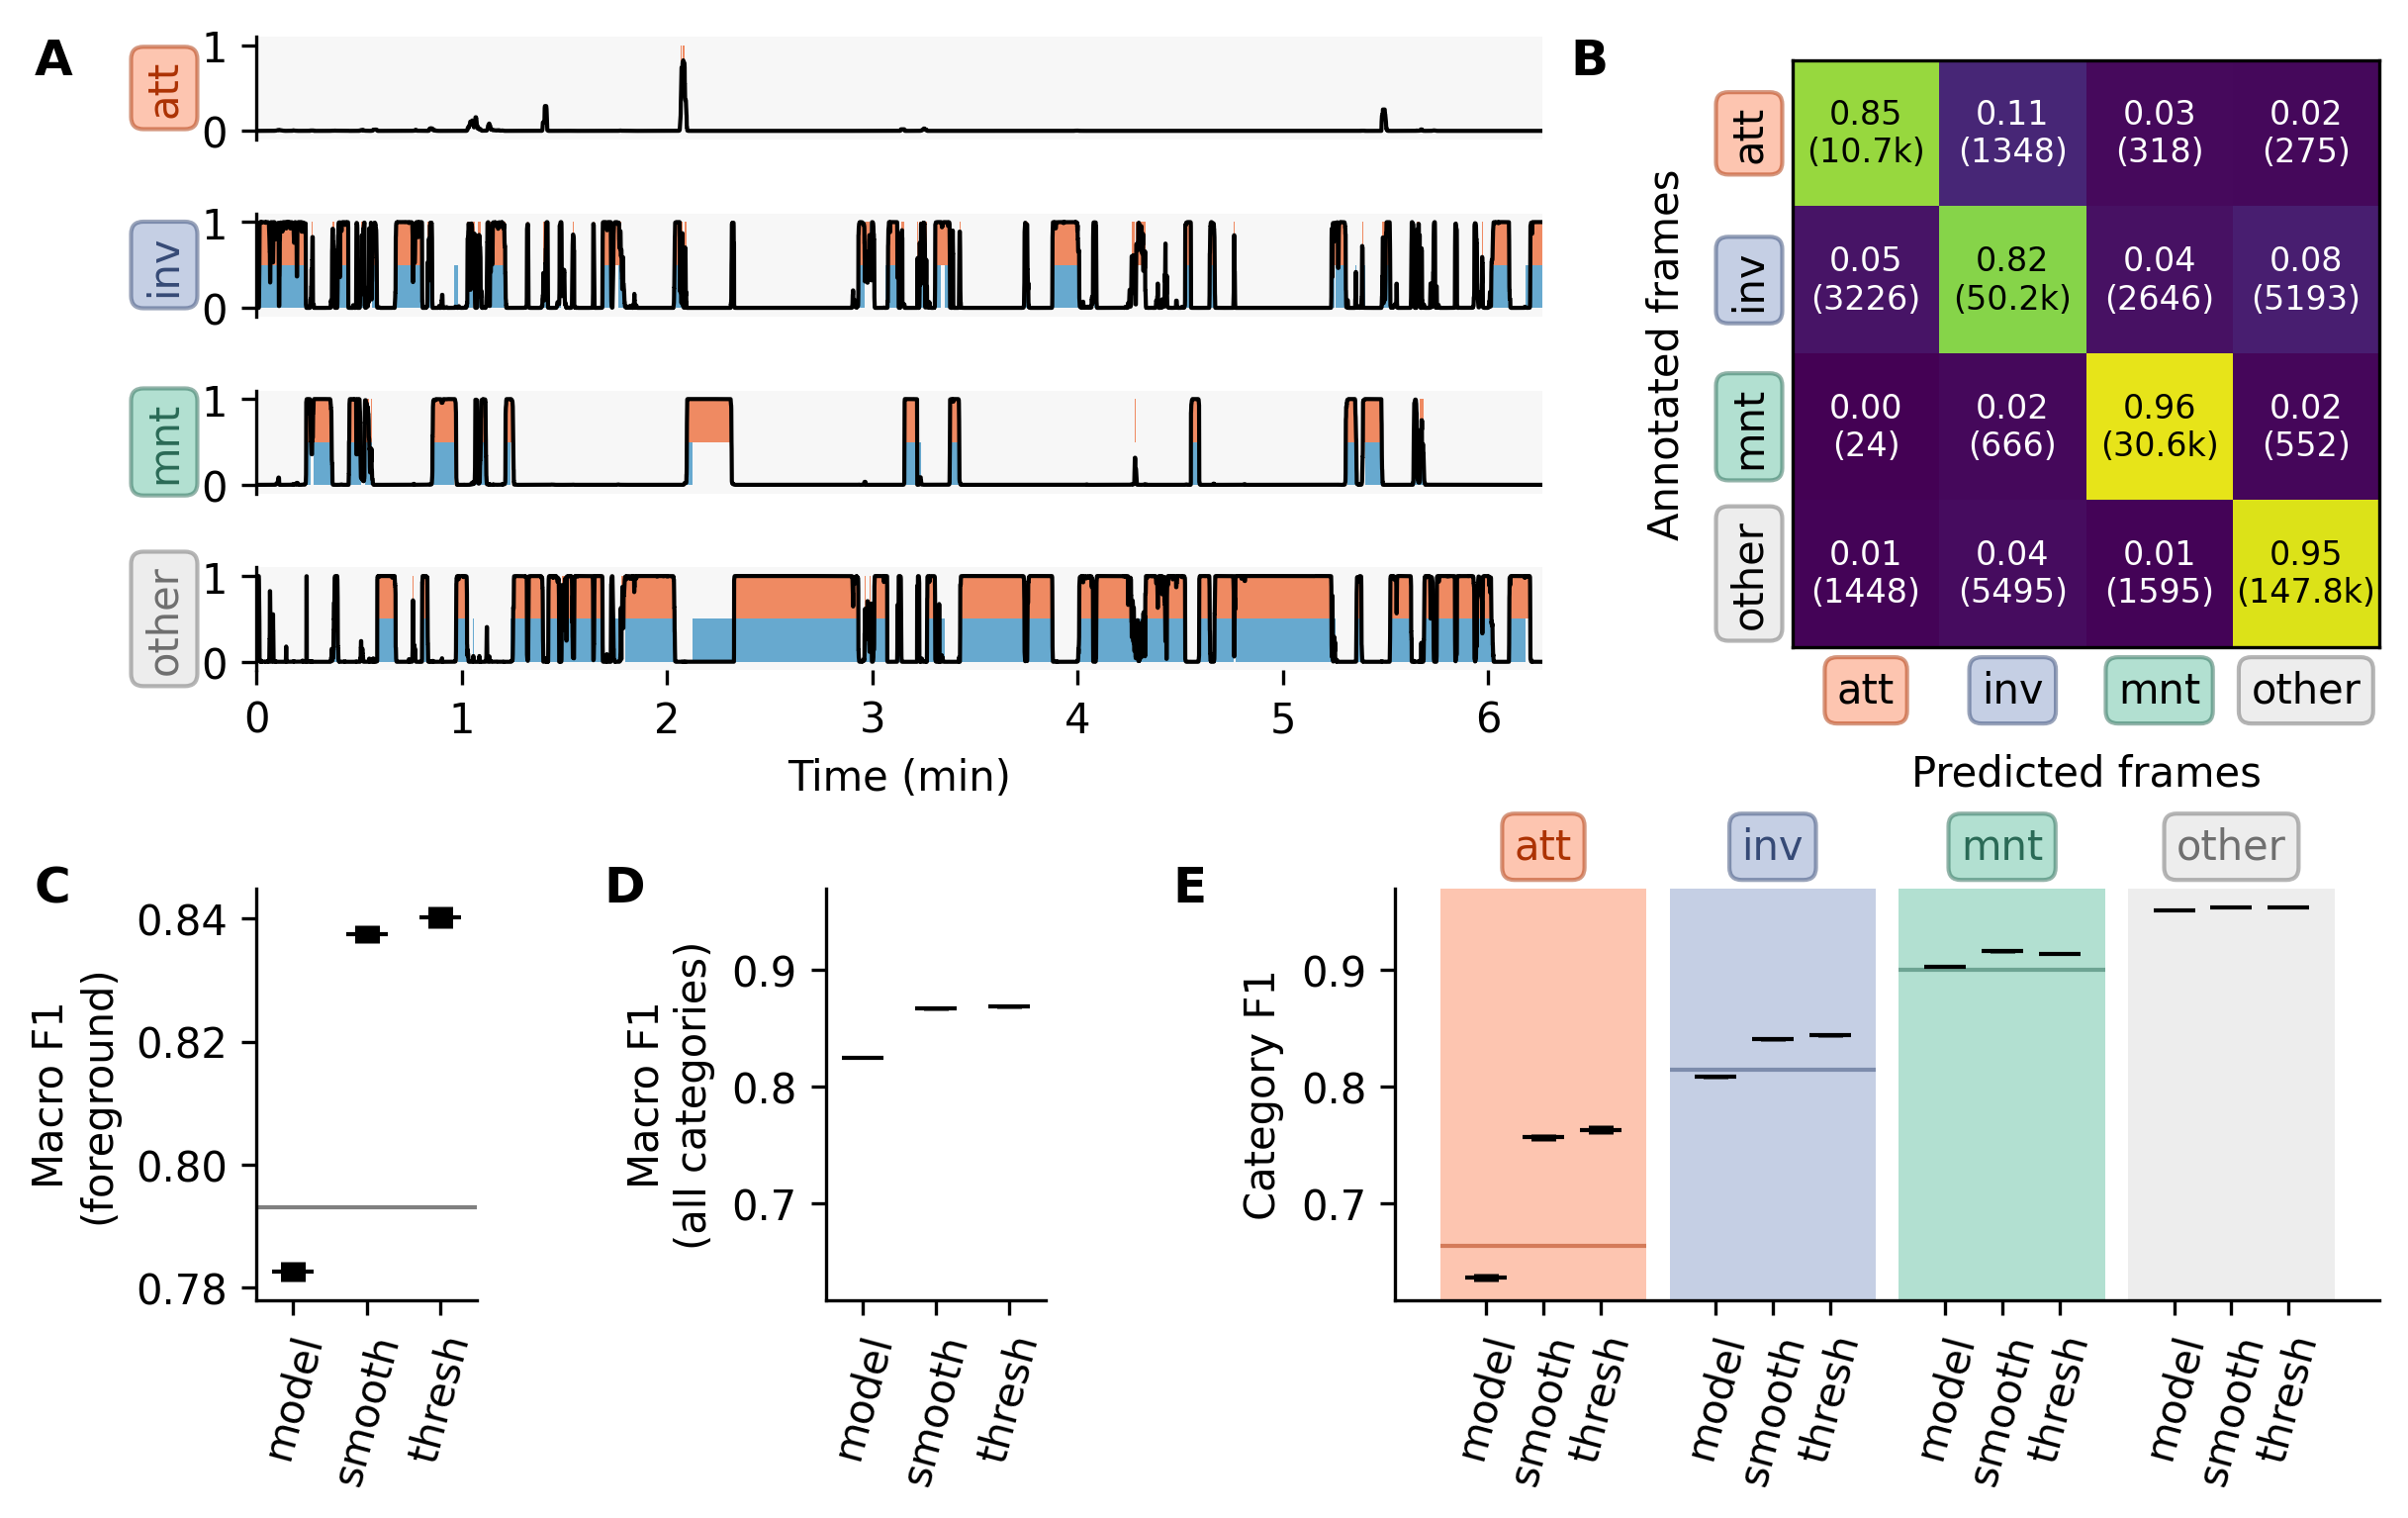

In [19]:
fig = plt.figure(layout="constrained", figsize=(8, 5), dpi=150)

gs = plt.GridSpec(5, 4, figure=fig, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1.5, 1.5, 1, 4])

ax1 = fig.add_subplot(gs[-1, 0])
ax2 = fig.add_subplot(gs[-1, 1])
ax3 = fig.add_subplot(gs[-1, 2:], sharey=ax2)

ax1.axhline(y=0.793, lw=1, c="grey")
means, stds = scores["timestamp"][["step", "f1_macro_foreground"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
ax1.errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax1.set_xticks(np.arange(means.size))
ax1.set_xlim(-0.5, means.size - 0.5)
ax1.set_xticklabels(["model", "smooth", "thresh"], rotation=75)
ax1.set_ylabel("Macro F1\n(foreground)")

means, stds = scores["timestamp"][["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
ax2.errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax2.set_xticks(np.arange(means.size))
ax2.set_xlim(-0.5, means.size - 0.5)
ax2.set_xticklabels(["model", "smooth", "thresh"], rotation=75)
ax2.set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = (
        pd.melt(scores["timestamp"].groupby("step").get_group(step).iloc[:, -4:], var_name="score")
        .groupby("score")
        .aggregate(("mean", "std"))
        .to_numpy()
    ).T
    ax3.errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax3.set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
ax3.set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color, baseline in zip(enumerate(category_labels), colors, [0.664, 0.814, 0.900, None]):
    ax3.axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    ax3.text(x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
             bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
             transform=transforms.blended_transform_factory(ax3.transData, ax3.transAxes))
    if baseline is not None:
        ax3.hlines(baseline, x - 0.2, x + 0.7, lw=1, alpha=0.5, color=adjust_lightness(color, 0.5), capstyle="butt")
ax3.set_ylabel("Category F1")

for ax in [ax1, ax2, ax3]:
    ax.spines[["right", "top"]].set_visible(False)


axes = [fig.add_subplot(gs[idx, :3]) for idx in range(len(category_labels))]

dyad_results = test_result.classification_results[18].classification_results[('resident', 'intruder')]
plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
    category_labels=category_labels,
    axes=axes,
)

for ax, color in zip(axes, colors):
    ax.set_ylabel(ax.get_ylabel(), color=adjust_lightness(color, 0.5), rotation=90,
                  va="bottom",
                  bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
ax.set_xlabel("Time (min)")

ax4 = fig.add_subplot(gs[:-1, 3])

plot_confusion_matrix(
    [y_true for y_true, _ in confusion["timestamp"]],
    [y_pred for _, y_pred in confusion["timestamp"]],
    ax=ax4,
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(ax4.get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(ax4.get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
ax4.tick_params(axis='both', which='major', pad=2, width=0)
ax4.set_ylabel("Annotated frames", labelpad=10)
ax4.set_xlabel("Predicted frames", labelpad=10)

fig.text(0, 1, "A", transform=(axes[0].transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='top', weight='semibold')
fig.text(0, 1, "B", transform=(ax4.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "C", transform=(ax1.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "D", transform=(ax2.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "E", transform=(ax3.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')

plt.show()

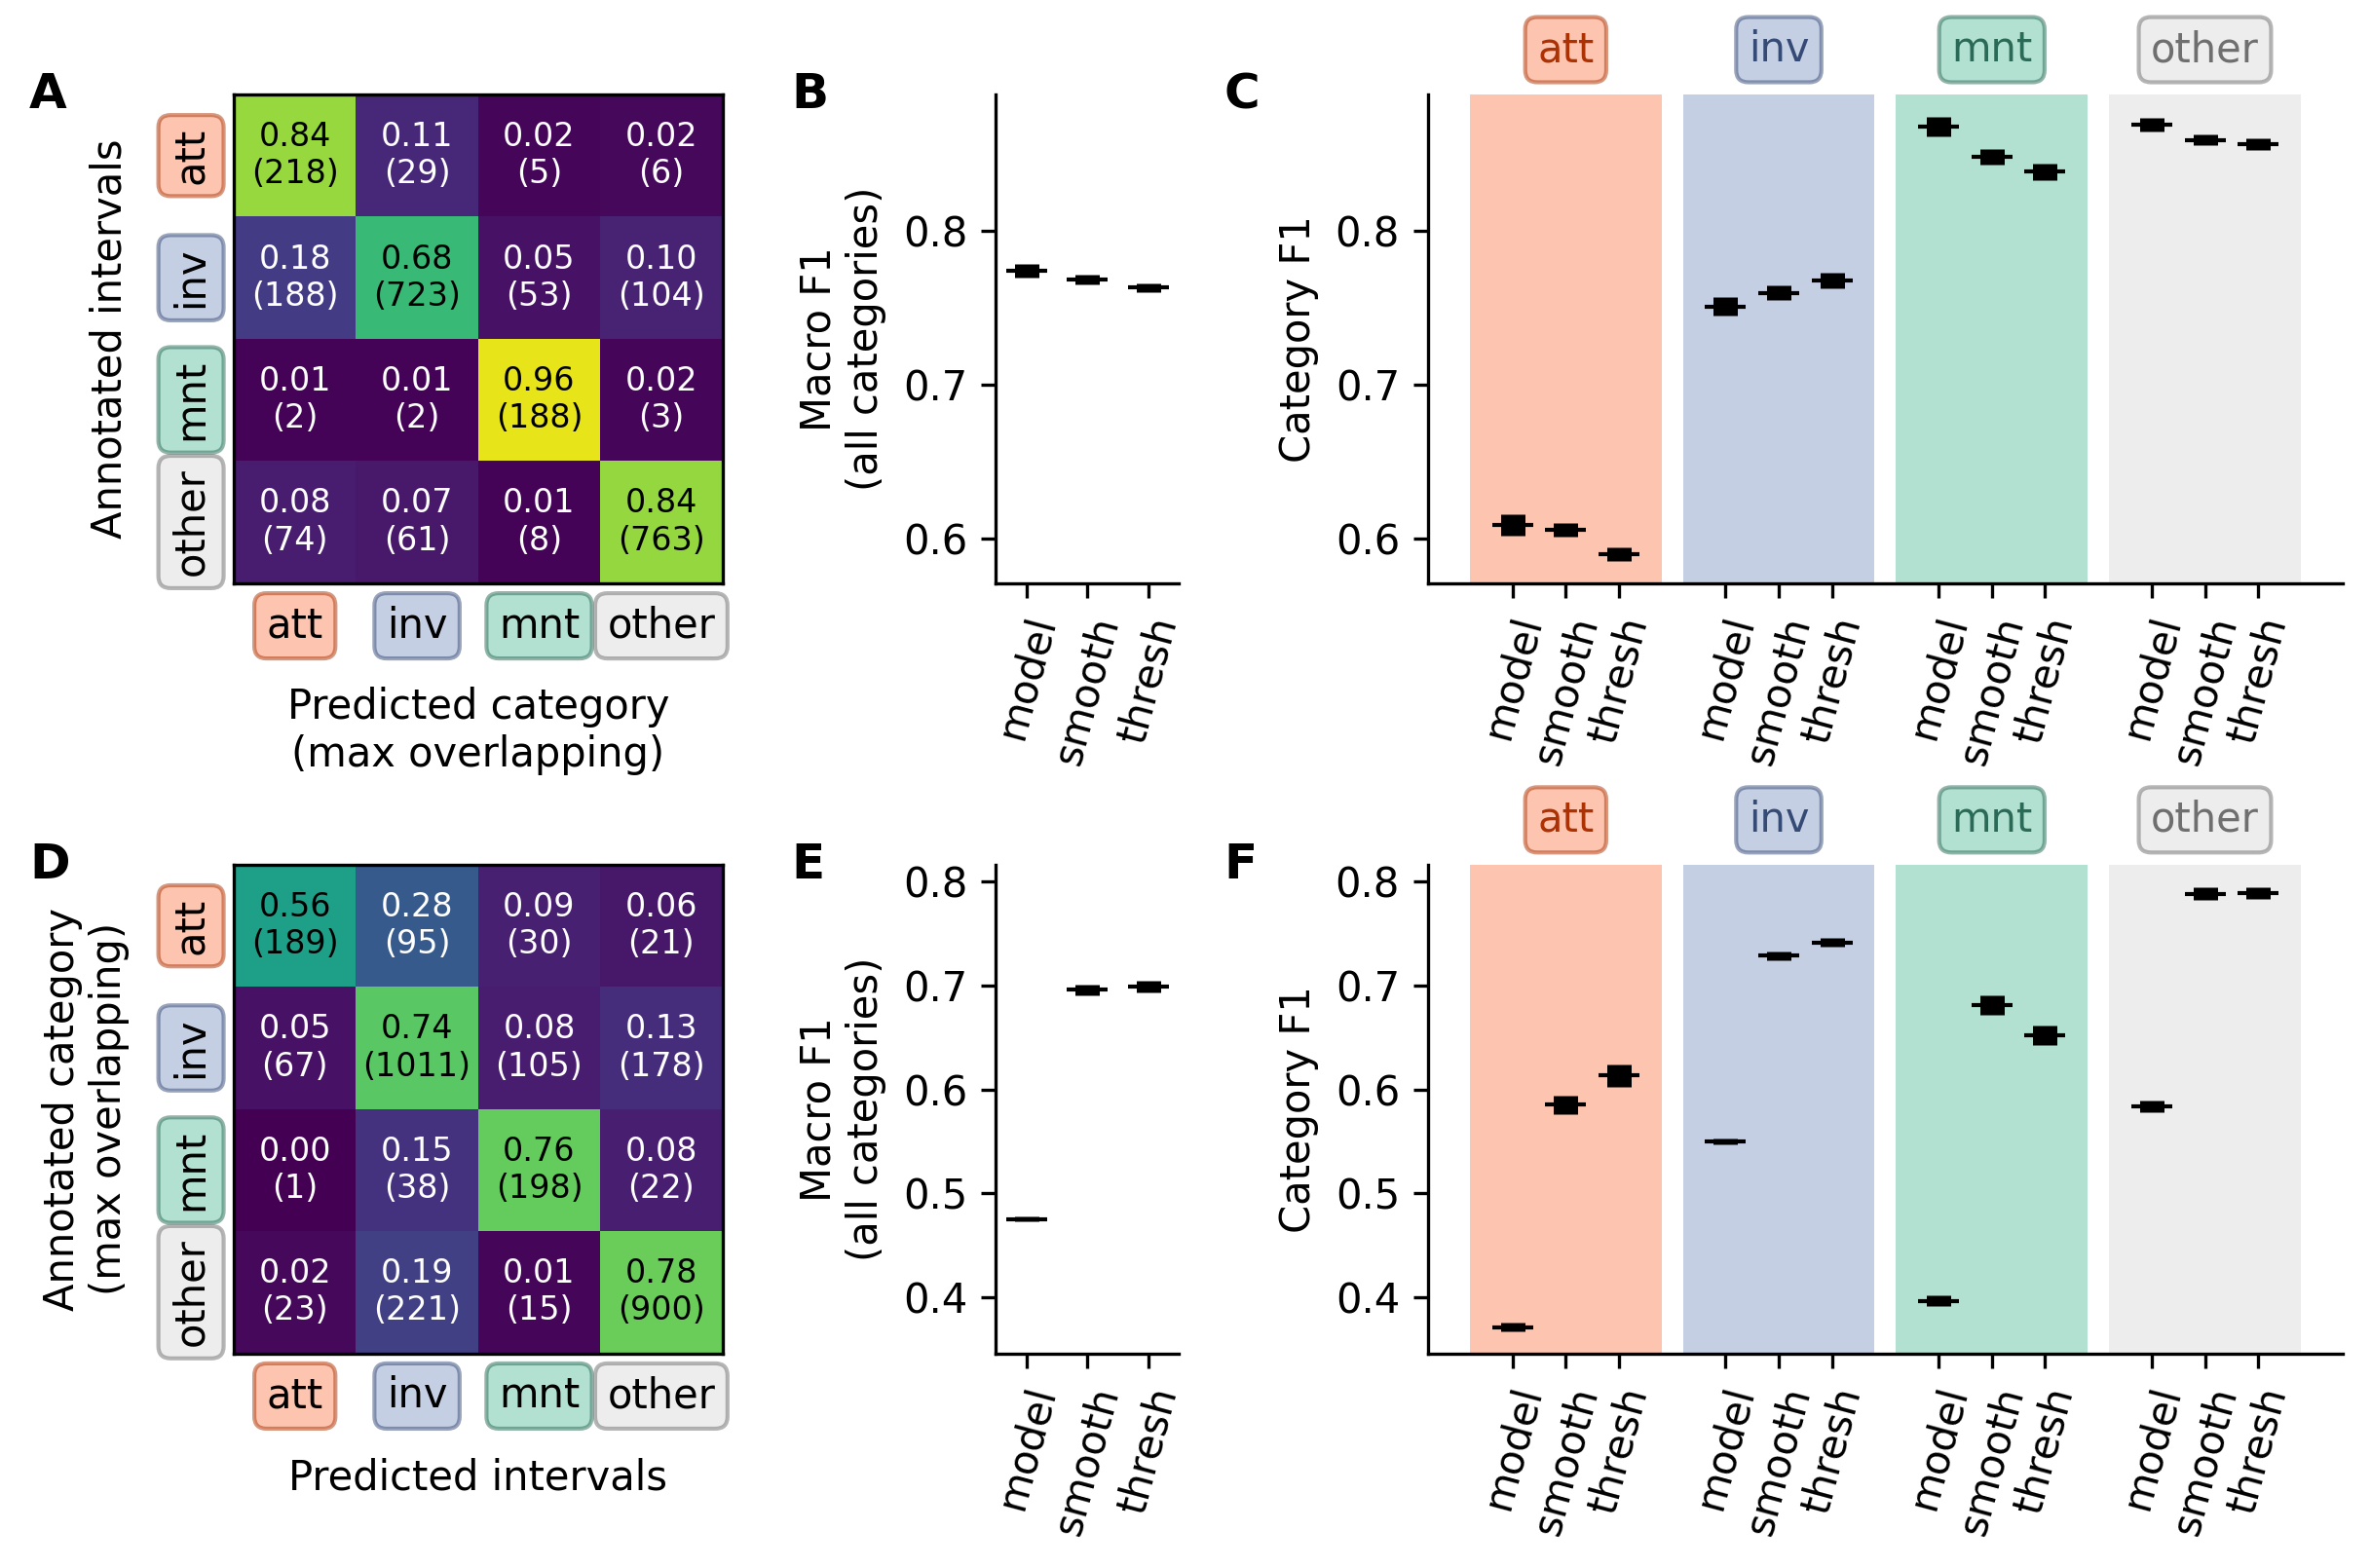

In [16]:
fig, axes = plt.subplots(2, 3, layout="constrained", figsize=(8, 5.25), dpi=150, width_ratios=[3, 1, 5])

plot_confusion_matrix(
    [y_true for y_true, _ in confusion["annotation"]],
    [y_pred for _, y_pred in confusion["annotation"]],
    ax=axes[0, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[0, 0].get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(axes[0, 0].get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
axes[0, 0].tick_params(axis='both', which='major', pad=2, width=0)
axes[0, 0].set_ylabel("Annotated intervals", labelpad=10)
axes[0, 0].set_xlabel("Predicted category\n(max overlapping)", labelpad=10)

means, stds = scores["annotation"][["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
axes[0, 1].errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[0, 1].set_xticks(np.arange(means.size))
axes[0, 1].set_xlim(-0.5, means.size - 0.5)
axes[0, 1].set_xticklabels(["model", "smooth", "thresh"], rotation=75)
axes[0, 1].set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = (
        pd.melt(scores["annotation"].groupby("step").get_group(step).iloc[:, -4:], var_name="score")
        .groupby("score")
        .aggregate(("mean", "std"))
        .to_numpy()
    ).T
    axes[0, 2].errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[0, 2].set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
axes[0, 2].set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color in zip(enumerate(category_labels), colors):
    axes[0, 2].axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    axes[0, 2].text(
        x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
        bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
        transform=transforms.blended_transform_factory(axes[0, 2].transData, axes[0, 2].transAxes),
    )
axes[0, 2].set_ylabel("Category F1")

plot_confusion_matrix(
    np.asarray([y_true for y_true, _ in confusion["prediction"]], dtype=object),
    np.asarray([y_pred for _, y_pred in confusion["prediction"]], dtype=object),
    ax=axes[1, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[1, 0].get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(axes[1, 0].get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
axes[1, 0].tick_params(axis='both', which='major', pad=2, width=0)
axes[1, 0].set_ylabel("Annotated category\n(max overlapping)", labelpad=10)
axes[1, 0].set_xlabel("Predicted intervals", labelpad=10)

means, stds = scores["prediction"][["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
axes[1, 1].errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[1, 1].set_xticks(np.arange(means.size))
axes[1, 1].set_xlim(-0.5, means.size - 0.5)
axes[1, 1].set_xticklabels(["model", "smooth", "thresh"], rotation=75)
axes[1, 1].set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = (
        pd.melt(scores["prediction"].groupby("step").get_group(step).iloc[:, -4:], var_name="score")
        .groupby("score")
        .aggregate(("mean", "std"))
        .to_numpy()
    ).T
    axes[1, 2].errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[1, 2].set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
axes[1, 2].set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color in zip(enumerate(category_labels), colors):
    axes[1, 2].axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    axes[1, 2].text(
        x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
        bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
        transform=transforms.blended_transform_factory(axes[1, 2].transData, axes[1, 2].transAxes),
    )
axes[1, 2].set_ylabel("Category F1")

for ax in [axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]:
    ax.spines[["right", "top"]].set_visible(False)

axes[0, 1].sharey(axes[0, 2])
axes[1, 1].sharey(axes[1, 2])

for ax, label in zip(axes.ravel(), ["A", "B", "C", "D", "E", "F"]):
    ax.text(0, 1, label, transform=(ax.transAxes + transforms.ScaledTranslation(-0.7, 0, fig.dpi_scale_trans)),
            fontsize=12, va='center', weight='semibold')

fig.get_layout_engine().set(wspace=0.05)

In [ ]:
# # recreate the a-soid "predicted ethogram" subpanel
# # this is actually visualizing the concatenation of all video sequences in the test set
# # note that this is very hard to interpret. -> skip

# fig, ax = plt.subplots(figsize=(4, 3))

# plt.scatter(
#     np.arange(test_result.y_true_numeric[::50].size),
#     test_result.y_true_numeric[::50],
#     s=2, alpha=0.5, lw=0,
# )

# plt.scatter(
#     np.arange(test_result.y_true_numeric[::50].size),
#     test_result.y_pred_numeric[::50] + 0.1,
#     s=2, alpha=0.5, lw=0,
# )

In [ ]:
# _, categories = subsample_train(dataset_train, extractor, exclude=[('intruder', 'resident')])
# unique_categories, counts = np.unique(categories, return_counts=True)

# print(unique_categories)
# print(counts, counts / counts.sum())

# counts = []

# for group_key in dataset_train.group_keys:
#     group = dataset_train.select(group_key)
#     for key in group.keys:
#         if key == ('intruder', 'resident'):
#             continue
#         dyad = group.select(key)
#         counts.append([dyad.category_idx(category).size for category in np.unique(unique_categories)])

# counts = np.asarray(counts)
# print(counts.sum(axis=0), counts.sum(axis=0) / counts.sum())

# counts = []

# for group_key in dataset_test.group_keys:
#     group = dataset_test.select(group_key)
#     for key in group.keys:
#         if key == ('intruder', 'resident'):
#             continue
#         dyad = group.select(key)
#         counts.append([dyad.category_idx(category).size for category in np.unique(unique_categories)])

# counts = np.asarray(counts)
# print(counts.sum(axis=0), counts.sum(axis=0) / counts.sum())